In [1]:
import os, sys, time, math
import tensorflow as tf
# import tensorlayer as tl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import cv2
# import network, img_io


## 1. Import LDR images 
these HDR images are derived from HDR image dataset from google. 
the code used for this procedure is function from MATLAB


### X: LDR images,  the hdrcnn simulated LDR
### y: True LDR images, from Matlab, or HDR images

In [2]:
def Extract_Filenames(dirpath):
    """Get all the filenames of .csv in the given directory
    Args:
        dirpath(string): the directory to search for the files.
    Returns:
        list: a list of filenames
    """

    import glob
#     dirpath = './test_data/'
    file_lst = [f for f in glob.glob("{}*.jpg".format(dirpath))]
    file_lst = [file_lst[i].split('\\')[-1].split('/')[-1]
                for i in range(len(file_lst))]
    file_lst = sorted(file_lst)
    return file_lst

In [46]:
def import_images(dirpath = './LDR data/'):
    # read data from <data> folder
    filenames = Extract_Filenames(dirpath)
    X = np.zeros((len(filenames), 1024, 1024))
    i=0   
    for name in filenames:
        image = cv2.imread(dirpath+name)
        x, y = abs(500*np.random.randn(2,1)).astype(np.int)
        x, y = x[0], y[0]
        image = image[y:y+1024, x:x+1024]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # turn into grayscale
        X[i,:,:] = gray
        i +=1
    return X

In [47]:
# X: simulated LDR images 152, 1208, 768, 3
# y: ground truth HDR images, 152, 4208 3120 3

X = import_images(dirpath = './LDR data/')
X.shape
y = import_images(dirpath = './HDR data/')
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(149, 1024, 1024)
(149, 1024, 1024)
(4, 1024, 1024)
(4, 1024, 1024)


In [48]:
sx,sy = X_train[0].shape
sz= 1
sx,sy,sz

(1024, 1024, 1)

## 3. create input pipeline for generating training/testing batches

In [49]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, sx,sy], name='input_LDR')
y_train_or_test = tf.placeholder(tf.float32, [None, sx,sy], name='ground_truth_HDR')

batch_size = 4

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)

batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [50]:
X_batch

<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 1024, 1024) dtype=float32>

## 4. create three pixel-level filters 

In [51]:
train_filters_1,train_filters_2,train_filters_3 = True,True,True

input_filter_1 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_1)
input_filter_2 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_2)
input_filter_3 = tf.Variable(np.ones([sx,sy]), dtype=tf.float32, trainable=train_filters_3)

In [52]:
input_filter_1

<tf.Variable 'Variable_3:0' shape=(1024, 1024) dtype=float32_ref>

## 5. generate the filtered images


In [53]:
X_filtered_1 = tf.multiply(X_batch, input_filter_1)
X_filtered_2 = tf.multiply(X_batch, input_filter_2)
X_filtered_3 = tf.multiply(X_batch, input_filter_3)

In [54]:
X_filtered_1

<tf.Tensor 'Mul_3:0' shape=(?, 1024, 1024) dtype=float32>

## 6. propagate back to the image plane: filtered LDR 


In [55]:
image_1 = tf.abs(X_filtered_1)**2
image_2 = tf.abs(X_filtered_2)**2
image_3 = tf.abs(X_filtered_3)**2

# add noise:
image_1 += tf.random.normal([sx,sy], mean=0, stddev=0.05)
image_2 += tf.random.normal([sx,sy], mean=0, stddev=0.05)
image_3 += tf.random.normal([sx,sy], mean=0, stddev=0.05)

In [56]:
image = (image_1 + image_2 + image_3)/3
image

<tf.Tensor 'truediv_1:0' shape=(?, 1024, 1024) dtype=float32>

 ## 7. process the filtered image through a Physical CNN to optimize filters

- ### Pass through Digital layer to get HDR output image.
- ### use the same loss as the Digital layer. 
loss is illumination + reflectance loss
I just need revise the hdrcnn_predict.py into a function, which return the HDR image and the loss?

revise get_final to return not only the HDR imgae, but also the cost. 

or should I define my own loss? 

FLAGS.sep_loss is the flag to separate loss into illumination and reflectance


### procedures problems? 

how about another loss? the filter does not have the same loss as the HDR images. 
I can define a loss, and train the network, then feed all the images to the Network, I don't need to change HDRCNN at all. 
just feed the processed LDR* images to the HDRCNN in one folder. 

# need to test, the tone mapping pic is better.

### Define Cost function

In [15]:
# this is from precious TA sessuion
net_input_layer = image[..., None]  # add a channels dimension
net_input_layer

# define your CNN here
net = net_input_layer

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)


# add some more if you want:
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

net = tf.layers.conv2d(net, filters=512, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=512, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)

net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=256, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.dropout(net, 0.5)

net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=128, kernel_size=3, padding='SAME', activation=tf.nn.relu)

net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)

net = tf.layers.conv2d(net, filters=2, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=1, kernel_size=1, activation=tf.nn.sigmoid)

# # fully connected layers:
# net = tf.layers.flatten(net)
# net = tf.layers.dense(net, units=500, activation=tf.nn.relu)
# net = tf.layers.flatten(net)
# net = tf.layers.dense(net, units=100, activation=tf.nn.relu)
# net = tf.layers.dense(net, units=1)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [19]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [77]:
    net_input_layer = image[..., None]  # add a channels dimension
    net_input_layer

    inputs = net_input_layer
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

In [81]:
#     model = Model(inputs = inputs, output = conv10)
loss = (tf.reduce_sum(tf.image.total_variation(conv10- y_batch)))/1024/1024
loss
# model.compile(optimizer = Adam(lr = 1e-4), loss = loss, metrics = ['accuracy'])
    

<tf.Tensor 'truediv_9:0' shape=() dtype=float32>

In [82]:
train_op = tf.train.AdamOptimizer(.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


## 8. Train

In [87]:
def plot_examples(batch):
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(batch[i])
        plt.colorbar()
        plt.axis('off')
    plt.show()

In [84]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

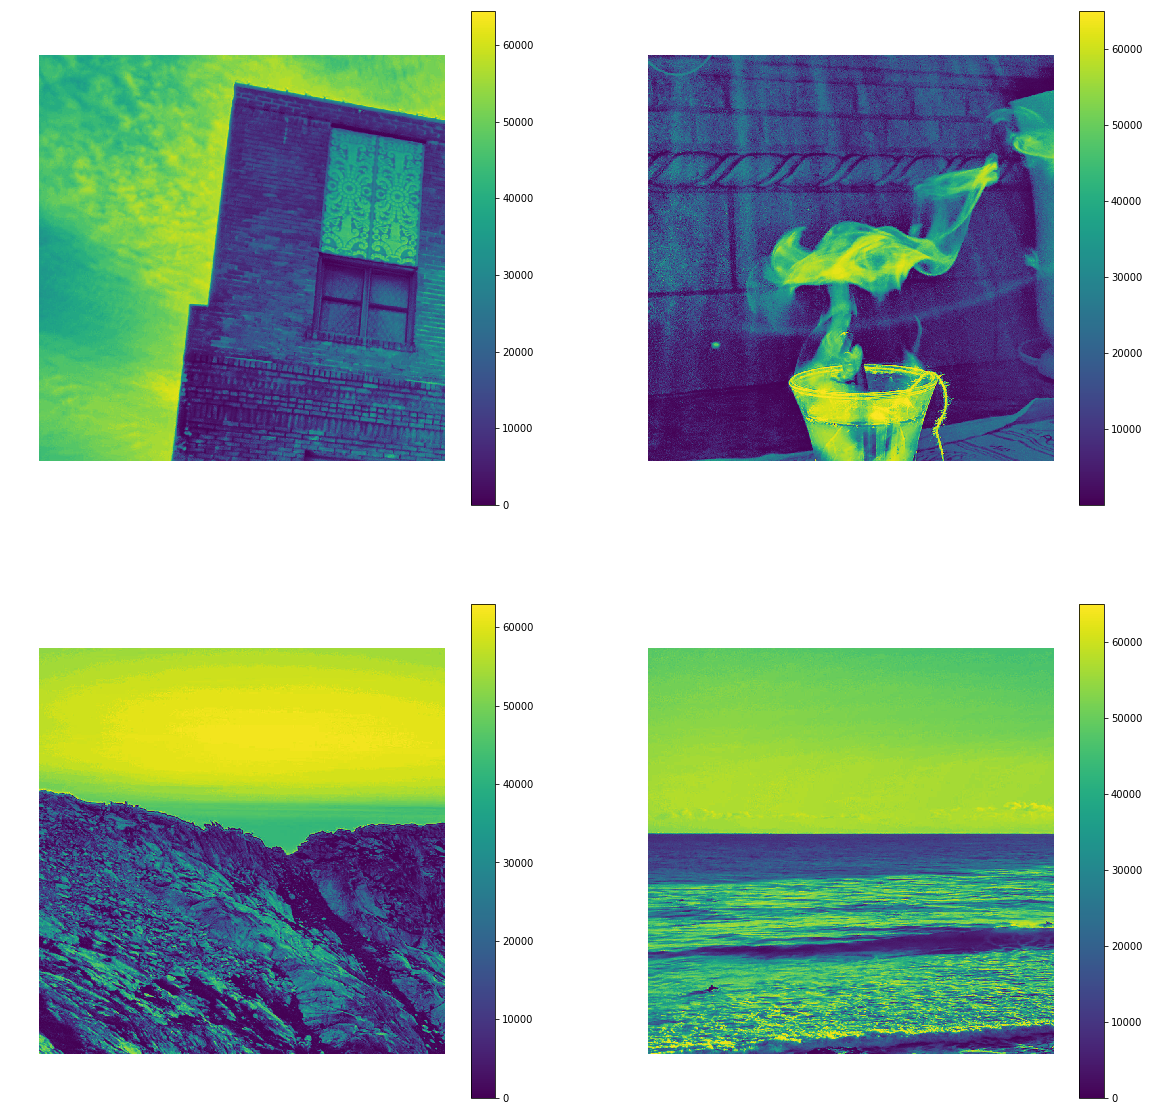

In [88]:
plot_examples(image.eval())

In [89]:
losses = list()
# train loop:
for i in range(2000):
    _, loss_i = sess.run([train_op, loss])
    losses.append(loss_i)
    if (i)%100 == 0:
        print('loss', i,':', loss_i)

InvalidArgumentError: Incompatible shapes: [4,1024,1024,1] vs. [4,1024,1024]
	 [[node gradients/sub_3_grad/BroadcastGradientArgs (defined at <ipython-input-82-0fbc593b2b6d>:1) ]]

Caused by op 'gradients/sub_3_grad/BroadcastGradientArgs', defined at:
  File "C:\Users\64877\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\64877\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\64877\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\64877\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\Users\64877\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\Users\64877\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\64877\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\64877\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-82-0fbc593b2b6d>", line 1, in <module>
    train_op = tf.train.AdamOptimizer(.01).minimize(loss)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 403, in minimize
    grad_loss=grad_loss)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\training\optimizer.py", line 512, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 664, in gradients
    unconnected_gradients)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 965, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 420, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 965, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 923, in _SubGrad
    rx, ry = gen_array_ops.broadcast_gradient_args(sx, sy)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 888, in broadcast_gradient_args
    "BroadcastGradientArgs", s0=s0, s1=s1, name=name)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

...which was originally created as op 'sub_3', defined at:
  File "C:\Users\64877\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 25 identical lines from previous traceback]
  File "C:\Users\64877\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-81-2aec0621fecb>", line 2, in <module>
    loss = (tf.reduce_sum(tf.image.total_variation(conv10- y_batch)))/1024/1024
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 812, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 10130, in sub
    "Sub", x=x, y=y, name=name)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\64877\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [4,1024,1024,1] vs. [4,1024,1024]
	 [[node gradients/sub_3_grad/BroadcastGradientArgs (defined at <ipython-input-82-0fbc593b2b6d>:1) ]]


In [44]:
# plot examples after the training
# plot_examples(image.eval())

In [45]:
input_filter_1.eval()
input_filter_2.eval()
input_filter_3.eval()

array([[ 0.03630399,  0.03492905,  0.0373841 , ...,  0.03246253,
         0.03158865,  0.03385535],
       [ 0.03883664,  0.03664777,  0.03393989, ...,  0.04061241,
         0.03308909,  0.03725617],
       [ 0.03924548,  0.03786309,  0.03455634, ...,  0.03940439,
         0.03223991,  0.03720113],
       ...,
       [ 0.01080893, -0.01781494,  0.00931775, ...,  0.00085296,
        -0.01262501,  0.00525969],
       [ 0.0048214 , -0.01985931,  0.01072116, ...,  0.00138833,
        -0.00893824,  0.00298611],
       [ 0.01257844, -0.0205526 , -0.00643346, ...,  0.01055615,
        -0.01011564, -0.00565652]], dtype=float32)

## 9. Results

In [ ]:
def compare_results():
    """plot:
    simulated_LDR
    simulated_HDR AFTER training
    simulated_HDR BEFORE training    
    ground_truth_HDR
    
    """ 
    
    pass